In [10]:
! pip install -q kaggle

In [11]:
from google.colab import files

In [12]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aydafrough","key":"6f11d390d25b1f8e7987d65c72badb9a"}'}

In [13]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset        Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           5809        234  1.0              
nelgiriyewithana/countries-of-the-world-2023                    Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33           4624        165  1.0              
byomokeshsenapati/spotify-song-attributes                       Spotify Song Attributes                             883KB  2023-07-09 16:00:20           1296         39  1.0              
arnavsmayan/netflix-userbase-dataset                        

In [18]:
!kaggle competitions download -c 'Food-11 image dataset'

403 - Forbidden - Permission 'competitions.participate' was denied


In [19]:
!kaggle datasets download -d trolukovich/food11-image-dataset

100% 1.08G/1.08G [00:58<00:00, 18.3MB/s]
100% 1.08G/1.08G [00:58<00:00, 20.0MB/s]


In [21]:
import zipfile
zip_ref = zipfile.ZipFile('food11-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [22]:
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path

In [25]:

train_path = Path('training')
validation_path = Path('validation')
evaluation_path = Path('evaluation')

In [38]:
#get the device
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

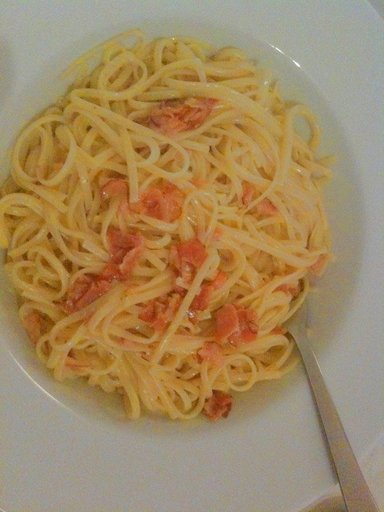

In [29]:
#open a random image to assess data
from PIL import Image
import random
image_path_list= list(train_path.glob("*/*.jpg"))
image_path=random.choice(image_path_list)
img=Image.open(image_path)
img


In [30]:
#get the class of image using stem
image_classes=image_path.parent.stem
print(image_classes)

Noodles-Pasta


In [31]:
#find out the shape of images
img_as_array=np.asarray(img)
img_as_array.shape

(512, 384, 3)

In [49]:
#set transform
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
data_transform=transforms.Compose([transforms.Resize(size=(224,224)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ToTensor(),
                                  normalize])

In [50]:
#create datasets useing ImageFolder
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_path,
                                transform=data_transform,
                                target_transform=None)
test_data=datasets.ImageFolder(root=validation_path,
                               transform=data_transform )

In [51]:
class_names=train_data.classes
class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [52]:
len(train_data), len(test_data)

(9866, 3430)

In [53]:
# create dataloaders
import os
batch_size=32
train_dataloader=DataLoader(dataset=train_data,
                           batch_size=batch_size,
                            num_workers=os.cpu_count(),
                           shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                          batch_size=batch_size,
                           num_workers=os.cpu_count(),
                          shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7facc963ead0>,
 <torch.utils.data.dataloader.DataLoader at 0x7facc963eb60>)

In [54]:
#get our pretrained model

weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [55]:
#freeze
for param in model.features.parameters():

  param.requires_grad=False

In [48]:
#tochinfo
!pip install torchinfo


In [56]:
#summary
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [42]:
# accuracy
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 12.0 MB/s eta 0:00:00


In [57]:
model.classifier= nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=11, bias=True)
)

In [43]:
from torchmetrics import Accuracy

In [60]:
#loss and optimizer , accuracy
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
accuracy=Accuracy(task="multiclass",num_classes=11).to(device)

In [64]:
#train step

epochs=10
train_loss,train_acc=0,0
test_loss, test_acc=0,0
for epoch in range(epochs):

  for batch,(x,y) in enumerate(train_dataloader):
    x,y=x.to(device), y.to(device)
    train_pred=model(x)

    loss=loss_fn(train_pred,y)
    train_loss +=loss.item()
    acc=accuracy(torch.argmax(torch.softmax(train_pred,dim=1),dim=1),y)
    train_acc +=acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss =train_loss/ len(train_dataloader)
  train_acc =train_acc/ len(train_dataloader)


  #test step
  model.eval()
  with torch.inference_mode():
    for batch,(x,y) in enumerate(test_dataloader):
      x,y=x.to(device), y.to(device)
      test_pred=model(x)

      loss=loss_fn(test_pred,y)
      test_loss +=loss.item()
      acc=accuracy(torch.argmax(torch.softmax(train_pred,dim=1),dim=1),y)
      test_acc +=acc.item()

  test_loss =test_loss/ len(test_dataloader)
  test_acc =test_acc/ len(test_dataloader)

  print(f"epoch: {epoch}, train_loss:{train_loss}, train_accuracy: {train_acc} /////// test_loss:{test_loss}, test_accuracy: {test_acc}")





epoch: 0, train_loss:0.5567419136419265, train_accuracy: 0.8316747573201324 
epoch: 1, train_loss:0.5037692556858495, train_accuracy: 0.8495563907232306 
epoch: 2, train_loss:0.46708752602952214, train_accuracy: 0.8648852956857003 
epoch: 3, train_loss:0.4299721162903855, train_accuracy: 0.8741379782260318 
epoch: 4, train_loss:0.4061655023277348, train_accuracy: 0.8822585370692044 
epoch: 5, train_loss:0.38121576074147706, train_accuracy: 0.8887775357186706 
epoch: 6, train_loss:0.3603837431317325, train_accuracy: 0.8987703156881539 
epoch: 7, train_loss:0.34187791202859386, train_accuracy: 0.9025647905884993 
epoch: 8, train_loss:0.32686907249761105, train_accuracy: 0.9093327339887036 
epoch: 9, train_loss:0.3109253449218196, train_accuracy: 0.9140269666995045 


In [65]:
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def plot_loss_curves(results:Dict[str, List[float]]):
  #plot training curves of a results dictionary
  #get the loss values of teh results dictionary(train, test)

  loss=results["train_loss"]
  #test_loss =results["test_loss"]

  #get the accuracy of the results dictionary
  accuracy=results["train_acc"]
  #test_accuracy=results["test_acc"]

  #figure out how many epochs there were
  epochs= range(len(results["train_loss"]))

  # set up plot
  plt.figure(figsize=(7,7))
  plt.plot(epochs, loss, label="train_loss")
  #plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

In [ ]:
plot_loss_curves()